In [1]:
import os.path as path
import pandas as pd
import urllib
import zipfile
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.mlab as mlab

import seaborn as sns
from scipy.stats.kde import gaussian_kde
%matplotlib inline

from statsmodels.nonparametric.kde import KDEUnivariate

#import statsmodels.api as sm
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import StandardScaler
%load_ext pep8_magic

ModuleNotFoundError: No module named 'pep8_magic'

# Exercice 1 - Expérience de Galton

## 1- Récupérer les données du fichier Galton.txt

In [2]:
# Le dataframe df reçoit le contenu du fichier filename:
filename = 'Galton'
df = pd.read_csv(filename + '.txt', sep='\t')

# conversion en centimetres des colonnes contenant des tailles
df[['Father', 'Mother', 'Height']] = \
df[['Father', 'Mother', 'Height']].apply(lambda x: x * 2.54)

# arrondir sans chiffre après la virgule
df = df.round({'Father': 0, 'Mother': 0, 'Height': 0})

df.head(5)

,Family,Father,Mother,Gender,Height,Kids
0,1,199.0,170.0,M,186.0,4
1,1,199.0,170.0,F,176.0,4
2,1,199.0,170.0,F,175.0,4
3,1,199.0,170.0,F,175.0,4
4,2,192.0,169.0,M,187.0,4


## 2- Données manquantes ?

In [3]:
miss = pd.isnull(df).values.any()
if miss:
    print("Valeurs manquantes")
else:
    print("Il ne manque aucune valeur dans cette base.")

Il ne manque aucune valeur dans cette base.


## 3- Afficher sur un même graphe un estimateur de la densité de la population des pères en bleu, et de celles des mères en orange.

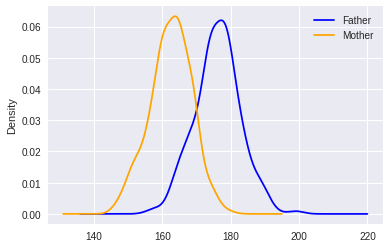

In [4]:
# on prend les enregistrements uniques 'Family','Kids','Father','Mother' 
df_unique = df[['Family', 'Kids', 'Father', 'Mother']]
df_unique = df_unique.drop_duplicates()

# on représente graphiquement un estimateur de la densité 
df_unique['Father'].plot(kind='kde', color='blue', legend=True)
df_unique['Mother'].plot(kind='kde', color='orange', legend=True)

## 4- Père fonction de la mère, et droite de prédiction obtenue par les moindres carrés

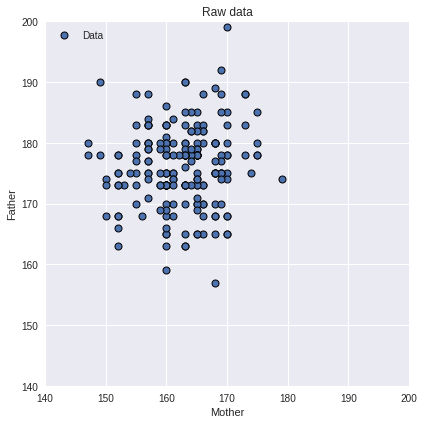

In [5]:
# On représente graphiquement la taille du père en fonction de celle
# de la mère
# La droite de prédiction est ajoutée dans la cellule suivante

X = df_unique[['Mother']]
y = df_unique['Father']

xlabels = 'Mother'
ylabels = 'Father'

tailleMin = 140
tailleMax = 200

fig1 = plt.figure(figsize=(6, 6))
plt.xlabel(xlabels)
plt.ylabel(ylabels)
plt.title('Raw data')
plt.plot(X, y, 'o', label="Data", markeredgecolor='k', markeredgewidth=1)

plt.xlim(xmin=tailleMin, xmax=tailleMax)
plt.ylim(ymin=tailleMin, ymax=tailleMax)

plt.legend(numpoints=1, loc=2)  # numpoints = 1 for nicer display
plt.tight_layout()
plt.show()

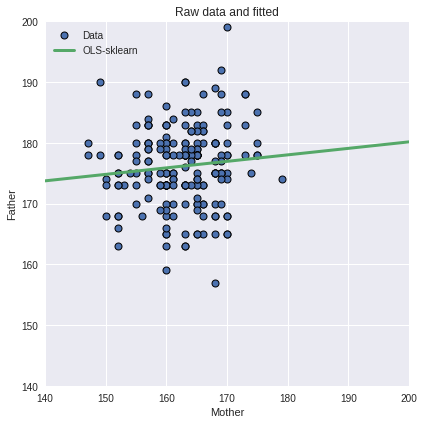

In [6]:
# On représente graphiquement la taille du père en fonction de celle
# de la mère, ainsi que la droite de prédiction 

xlabels = 'Mother'
ylabels = 'Father'

X = df_unique[['Mother']]
y = df_unique['Father']

# régression avec constante
skl_linmod = linear_model.LinearRegression(fit_intercept=True)
skl_linmod.fit(X, y)

# représentation graphique
fig1 = plt.figure(figsize=(6, 6))
plt.xlabel(xlabels)
plt.ylabel(ylabels)
plt.plot(X, y, 'o', label="Data", markeredgecolor='k', markeredgewidth=1)

plt.xlim(xmin=tailleMin, xmax=tailleMax)
plt.ylim(ymin=tailleMin, ymax=tailleMax)

X_to_predict = np.linspace(tailleMin, tailleMax, num=10).reshape(10, 1)

plt.plot(X_to_predict, skl_linmod.predict(X_to_predict),
         linewidth=3, label="OLS-sklearn")
plt.legend(numpoints=1, loc=2)  # numpoints = 1 for nicer display
plt.xlabel(xlabels), plt.ylabel(ylabels)
plt.title('Raw data and fitted')
plt.tight_layout()
plt.show()

## 5- Afficher un histogramme du nombre de familles par nombre d'enfants

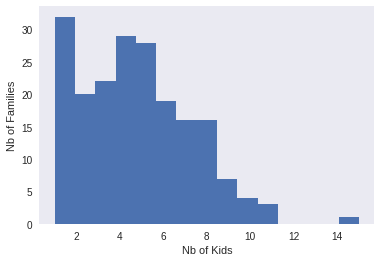

In [7]:
df_enfantsParFamille = df_unique[['Family', 'Kids']]
df_2 = df_enfantsParFamille['Kids']
ax = df_2.hist(grid=False, bins=np.max(df_enfantsParFamille['Kids']))
ax.set_xlabel("Nb of Kids")
ax.set_ylabel("Nb of Families")

## 6- Créer une colonne supplémentaire appelée 'MidParents'

In [8]:
df['MidParents'] = (df['Father'] + 1.08 * df['Mother']) / 2.
df.head(5)

,Family,Father,Mother,Gender,Height,Kids,MidParents
0,1,199.0,170.0,M,186.0,4,191.30
1,1,199.0,170.0,F,176.0,4,191.30
2,1,199.0,170.0,F,175.0,4,191.30
3,1,199.0,170.0,F,175.0,4,191.30
4,2,192.0,169.0,M,187.0,4,187.26


## 7- Estimer θ0 , θ1 , par θ0 , θ1 en utilisant la fonction LinearRegression de sklearn

In [9]:
# X représente le vecteur taille moyenne des parents
# y le vecteur des tailles des enfants

X = df[['MidParents']]
y = df['Height']

xlabels = 'MidParents'
ylabels = 'Height'

# Régression linéaire avec constante
skl_linmod = linear_model.LinearRegression(fit_intercept=True)
skl_linmod.fit(X, y)

# Calcul et affichage des estimations
theta0 = skl_linmod.intercept_
theta1 = skl_linmod.coef_

print("theta0 estimé : ", theta0)
print("theta1 estimé : ", theta1.item())

theta0 estimé :  58.255916588
theta1 estimé :  0.6330937666628673


In [10]:
# calcul manuel :

varX = df.var()['MidParents']
varY = df.var()['Height']

corr = df[['MidParents', 'Height']] \
    .corr(method='pearson', min_periods=1)['MidParents']['Height']

theta1_computed = corr * np.sqrt(varY) / np.sqrt(varX)

theta0_computed = df['Height'].mean() - \
    theta1_computed * df['MidParents'].mean()

print("theta0 calculé : ", theta0_computed)
print("theta1 calculé : ", theta1_computed.item())

if(np.isclose(theta0_computed, theta0)):
    print("\nLe theta0 estimé est égal au theta0 calculé")
else:
    print("\nLe theta0 estimé est différent du théta0 calculé !!")

if(np.isclose(theta1_computed, theta1)):
    print("Le theta1 estimé est égal au theta1 calculé")
else:
    print("Le theta1 estimé est différent du théta1 calculé !!")

theta0 calculé :  58.255916588
theta1 calculé :  0.6330937666628672

Le theta0 estimé est égal au theta0 calculé
Le theta1 estimé est égal au theta1 calculé


## 8- Calculer et visualiser les valeurs prédites yi = θ0 + θ1xi et les yi sur un même graphique. 

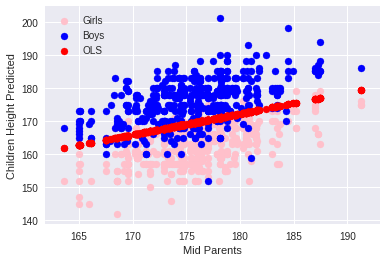

In [11]:
# on ajoute une colonne dans le dataframe, qui contient les valeurs prédites
df['y_predicted'] = theta0 + theta1 * df['MidParents']

# on filtre les filles, et les garcons
df_girls = df[df['Gender'] == 'F']
df_boys = df[df['Gender'] == 'M']

# on représente les nuages associés
plt.scatter(df_girls['MidParents'], df_girls['Height'],
            color = 'pink', label='Girls')
plt.scatter(df_boys['MidParents'], df_boys['Height'],
            color = 'blue', label='Boys')
plt.xlabel("Mid Parents")
plt.ylabel("Children Height Predicted")

# ainsi que la droite des y prédits
plt.scatter(df['MidParents'], df['y_predicted'], color='red', label="OLS")
plt.legend(numpoints=1, loc=2)

plt.show()

## 9- Visualiser un estimateur de la densité des résidus 
## Calculer ensuite αg (resp. αf ) les proportions de garçons (resp. de filles) dans la population. 
## On ajoutera ensuite sur le graphique précédent, les fonctions αgpg et αfpf, avec pg (resp. pf) les densités des résidus pour les garçons (resp. pour les filles).

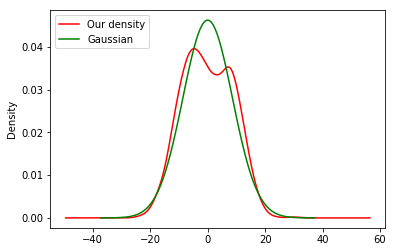

A voir la superposition des deux courbes, l'hypothèse de normalité paraît raisonnable


In [12]:
# on ajoute une colonne dans le dataframe, qui contient les résidus, 
# résidu = yobservé - y prédit
df['residu'] = df['Height'] - df['y_predicted']

# afficher un estimateur de la densité (en rouge ci-dessous) :
df['residu'].plot(kind='kde', color='red', label='Our density')

# L'hypothèse de normalité est-elle raisonnable?
# Représentons sur le même graphe, en vert, la gaussienne
# de moyenne la moyenne des residus, et de variance la 
# variance des résidus
mean_residu = np.mean(df['residu'])
var_residu = np.var(df['residu'])

sigma = math.sqrt(var_residu)
x = np.linspace(mean_residu-0.5*var_residu, mean_residu+0.5*var_residu, 100)
plt.plot(x, mlab.normpdf(x, mean_residu, sigma), color='green', label='Gaussian')

plt.legend(numpoints=1, loc=2)
plt.show()

print("A voir la superposition des deux courbes, " +
      "l'hypothèse de normalité paraît raisonnable")

In [13]:
# calculer les proportions de garcons et de filles

nbChildrenByGender = df['Gender'].groupby(df['Gender']).count()

alpha_boys = nbChildrenByGender['M'] / df['Gender'].count()
alpha_girls = nbChildrenByGender['F'] / df['Gender'].count()

print('Proportion de garcons : {:.2%}'.format(alpha_boys))
print('Proportion de filles : {:.2%}'.format(alpha_girls))

Proportion de garcons : 51.78%
Proportion de filles : 48.22%


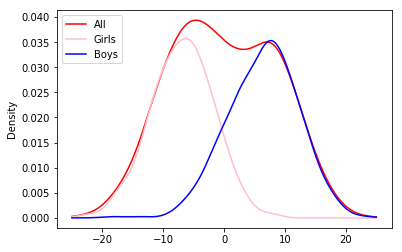

In [14]:
# On représente sur un meme graphe, la densité des résidus
# et celles des résidus masculins et féminins

df_girls = df[df['Gender'] == 'F']
df_boys = df[df['Gender'] == 'M']

tailleMin = -25
tailleMax = 25

xrange_lim = (tailleMin, tailleMax)

# All
kde = KDEUnivariate(df['residu']) 
kde.fit(kernel='gau')
x_grid = np.linspace(xrange_lim[0], xrange_lim[1], 400)
pdf_est = kde.evaluate(x_grid)

plt.plot(x_grid, pdf_est, color='r', label='All')

# Girls
kde = KDEUnivariate(df_girls['residu']) 
kde.fit(kernel='gau')
pdf_est_g = kde.evaluate(x_grid)

plt.plot(x_grid, pdf_est_g*alpha_girls, color='pink', label='Girls')

# Boys
kde = KDEUnivariate(df_boys['residu']) 
kde.fit(kernel='gau')
pdf_est_b = kde.evaluate(x_grid)

plt.plot(x_grid, pdf_est_b*alpha_boys, color='b', label='Boys')

plt.legend(numpoints=1, loc=2)  # numpoints = 1 for nicer display
plt.ylabel("Density")

plt.show()

## 10- Régresser cette fois les xi sur les yi (et non plus les yi sur les xi).

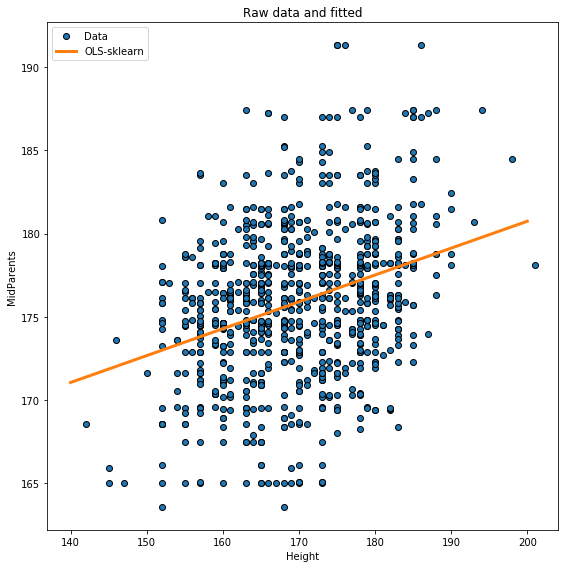

In [15]:
# régression des xi sur les yi :

ylabels = 'MidParents'
xlabels = 'Height'

y = df['MidParents']
X = df[['Height']]

# Fit regression model with intercept (with sklearn)
skl_linmod = linear_model.LinearRegression(fit_intercept=True)
skl_linmod.fit(X, y)

fig = plt.figure(figsize=(8, 8))
plt.plot(X, y, 'o', label="Data", markeredgecolor='k', markeredgewidth=1)
X_to_predict = np.linspace(140, 200, num=200).reshape(200, 1)

plt.plot(X_to_predict, skl_linmod.predict(X_to_predict), linewidth=3, \
         label="OLS-sklearn")
plt.legend(numpoints=1, loc=2)  # numpoints = 1 for nicer display
plt.xlabel(xlabels), plt.ylabel(ylabels)
plt.title('Raw data and fitted')
plt.tight_layout()
plt.show()

In [16]:
# On obtient : 
alpha0 = skl_linmod.intercept_
alpha1 = skl_linmod.coef_

print ("alpha0 estimé : ", alpha0)
print ("alpha1 estimé : ", alpha1.item())

alpha0 estimé :  148.437160448
alpha1 estimé :  0.16149030293099906


In [17]:
# calcul manuel des alpha0 et alpha1

x_mean = df['MidParents'].mean()
y_mean = df['Height'].mean()
varX = df.var()['MidParents']
varY = df.var()['Height']
alpha0_computed = x_mean + (y_mean / x_mean) * (varX / varY) \
    * (theta0_computed - y_mean)

alpha1_computed = (varX / varY) * theta1_computed

print("alpha0 calculé : ", alpha0_computed)
print("alpha1 calculé : ", alpha1_computed.item())

if(np.isclose(alpha0_computed, alpha0)):
    print("Le alpha0 estimé est égal au alpha0 calculé")
else:
    print("Le alpha0 estimé est différent du alpha0 calculé !!")
    
if(np.isclose(alpha1_computed, alpha1)):
    print("Le alpha1 estimé est égal au alpha1 calculé")
else:
    print("Le alpha1 estimé est différent du alpha1 calculé !!")

alpha0 calculé :  148.437160448
alpha1 calculé :  0.16149030293099859
Le alpha0 estimé est égal au alpha0 calculé
Le alpha1 estimé est égal au alpha1 calculé


# Exercice 2 - Analyse du jeu de données auto-mpg

In [12]:
# utilitaire :

# cette fonction est utilisée dans la plupart des questions
# suivantes pour afficher la valeur de theta1, avec le nom des
# colonnes qui correspondent
# L'idée est de créer un dictionnaire qui fait correspondre les
# noms des colonnes de la matrice X, avec les valeurs de theta1,
# et de le renvoyer sous forme de dataframe


def convertThetaIntoDF(theta, columns):
    dico = {}
    for a, b in zip(columns, theta):
        dico[a] = b
    df = pd.DataFrame.from_dict(dico, orient='index') \
        .rename(columns={0: 'value'})
    return df

## 11- Importer avec Pandas la base de données auto-mpg 

In [14]:
# Le dataframe df reçoit le contenu du fichier filename:
filename = 'auto-mpg.data'
naValues = ['Na']
names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
         'acceleration', 'model year', 'origin', 'car name']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/' +\
      'auto-mpg.data-original', sep=r"\s+", names=names, 
                 header=None, na_values=naValues)

# Les valeurs manquantes sont à Na, d'après la description des colonnes 
# du fichier
# La fonction 'count' montre le nombre de valeurs non "null" par colonne
# On constate que les colonnes 'mpg' et 'horsepower' en contiennent, 
# que l'on va supprimer :

print(df.count())
df.dropna(inplace=True, how='any')
df = df.reset_index(drop=True)

# Nombre de données manquantes après nettoyage:
print("\n{} valeur(s) manquante(s) dans la colonne mpg !!"
      .format(df[df['mpg'].isnull()].shape[0]))
print("{} valeur(s) manquante(s) dans la colonne horsepower !!"
      .format(df[df['horsepower'].isnull()].shape[0]))

print("\nLe nettoyage est fait :\n")

print(df.count())

mpg             398
cylinders       406
displacement    406
horsepower      400
weight          406
acceleration    406
model year      406
origin          406
car name        406
dtype: int64

0 valeur(s) manquante(s) dans la colonne mpg !!
0 valeur(s) manquante(s) dans la colonne horsepower !!

Le nettoyage est fait :

mpg             392
cylinders       392
displacement    392
horsepower      392
weight          392
acceleration    392
model year      392
origin          392
car name        392
dtype: int64


## 12- Calculer l'estimateur des moindres carrés

In [15]:
# on ne conserve que les 9 premières lignes pour cette étude :
df_9 = df[:9]

# régression linéaire 
xlabels = 'Features'
ylabels = 'Mpg'

X = df_9[['cylinders', 'displacement', 'horsepower', 'weight', 
         'acceleration', 'model year']]
y = df_9['mpg']

# Fit regression model without intercept (with sklearn)
skl_linmod = linear_model.LinearRegression(fit_intercept=True)
skl_linmod.fit(X, y)

# Affichage de l'estimateur des moindres carrés:
theta0 = skl_linmod.intercept_
theta1 = skl_linmod.coef_

print("theta0 calculé : ", theta0)
print("theta1 calculé : ", theta1)

print("\nNous constatons que les features 'cylinders' et 'model year'" \
       " ne sont pas explicatives,\n" \
       "car theta1[0] = 0 et theta1[5] = 0\n")

# Calcul de mpg estimé : 
y_est = theta0 + X.dot(theta1)
# y_est2 = skl_linmod.predict(X)

print("Mpg estimé :")
print(y_est)
# print (y_est2)

theta0 calculé :  30.7716953656
theta1 calculé :  [ 0.          0.05408848 -0.0945306  -0.00424074 -0.19936701  0.        ]

Nous constatons que les features 'cylinders' et 'model year' ne sont pas explicatives,
car theta1[0] = 0 et theta1[5] = 0

Mpg estimé :
0    17.835934
1    16.151352
2    17.028033
3    16.084149
4    17.152477
5    14.855885
6    14.272661
7    14.265870
8    13.353638
dtype: float64


## 13- Calculer l'estimateur des moindres carrés sur l'ensemble des données centrées réduites

In [16]:
X = df[['cylinders', 'displacement', 'horsepower', 'weight', 
         'acceleration', 'model year']]
y = df['mpg']

# Les données sont centrées et réduites
scaler = preprocessing.StandardScaler()
Xprime = scaler.fit_transform(X)

# Fit regression model 
skl_linmod = linear_model.LinearRegression()
skl_linmod.fit(Xprime, y)

# Calcul de l'estimateur :
theta1 = skl_linmod.coef_

# Comme on cherche les variables qui ont un impact, sans préciser le 
# sens de cet impact, je prends la valeur absolue de theta1, et 
# j'ordonne de manière décroissante:
df_theta1 = convertThetaIntoDF(abs(theta1), X.columns)
df_theta1 = df_theta1.sort_values('value', ascending=False)

# Affichage du theta1 et de la conclusion
print("Theta1 calculé (ordre décroissant, en valeur absolue) : \n")
print(df_theta1)
df_theta1 = df_theta1.reset_index()
print("\nNous constatons que, sur l'ensemble des données, c'est '" + 
       df_theta1['index'][0] + "' et '" + df_theta1['index'][1] + 
       "' qui ont le plus d'impact")

# Calcul de la gpm estimée (pour la question 14):
y_est = skl_linmod.predict(Xprime)

Theta1 calculé (ordre décroissant, en valeur absolue) : 

                 value
weight        5.764000
model year    2.771664
displacement  0.802476
cylinders     0.561950
acceleration  0.234957
horsepower    0.015045

Nous constatons que, sur l'ensemble des données, c'est 'weight' et 'model year' qui ont le plus d'impact


## 14- Calcul de la norme de r au carré

In [17]:
# Calculer la norme des résidus au carré
residu = y - y_est
normeResidus = np.linalg.norm(residu)**2
print("La norme au carré des résidus vaut :", normeResidus)

# calculer la norme au carré des résidus, divisée par (n-p)
p = 6
n = df['mpg'].count()

NormeSurNMoinsP = normeResidus / (n-p)
print("La norme au carré des résidus, divisée par (n-p) vaut :", 
      NormeSurNMoinsP)

# Vérifier le calcul sur les normes :

# On calcule la norme de y - y_moy
y_moy = y.mean()
normeYMoinsMoy = np.linalg.norm(y-y_moy)**2

# on calcule la deuxième partie de l'égalité
partie2 = normeResidus + np.linalg.norm(y_est-y_moy)**2

if np.isclose(normeYMoinsMoy, partie2) is True:
    print("L'égalité est vérifiée")
else:
    print('Problème')

La norme au carré des résidus vaut : 4543.34702471
La norme au carré des résidus, divisée par (n-p) vaut : 11.7703290796
L'égalité est vérifiée


## 15- Prédire la consommation d'un nouveau véhicule

In [23]:
# on a une nouvelle ligne dans X : 
# ['cylinders','displacement','horsepower','weight', 'acceleration',
# 'model year']
# [6, 225, 100, 3233, 15.4, 76]

X_new = pd.DataFrame([[6, 225, 100, 3233, 15.4, 76]])

# Appliquer à X_new la normalisation apprise sur le trainset
X_new_prime = scaler.transform(X_new)

# Calculer une estimation de la consommation, en appliquant 
# la régression apprise sur le trainset :
y_est_new = skl_linmod.predict(X_new_prime)

# On affiche le y estimé : 
print(y_est_new[0], "mpg est une estimation de la consommation" +
      " pour cette voiture")

21.7762201826 mpg est une estimation de la consommation pour cette voiture


## 16. Utilisation de la transformation PolynomialFeatures

In [24]:
X = df[['cylinders', 'displacement', 'horsepower', 'weight',
         'acceleration', 'model year']]
y = df['mpg']

# On effectue le feature engineering proposé :
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, 
                                        include_bias=False)
X_transformed = poly.fit_transform(X)

# Les données sont centrées et réduites
scaler = preprocessing.StandardScaler()
Xprime = scaler.fit_transform(X_transformed)

# Fit regression model 
skl_linmod = linear_model.LinearRegression(fit_intercept=True)
skl_linmod.fit(Xprime, y)

# Affichage de l'estimateur :
theta0 = skl_linmod.intercept_
theta1 = skl_linmod.coef_

# On prend la valeur absolue du vecteur pour trouver la variable 
# la plus explicative :
theta1_clean = np.abs(theta1)

# Conclusion
print("Après cette manipulation, la variable la plus explicative devient '" + \
      poly.get_feature_names(X.columns)[np.argmax(theta1_clean)] + "'")

Après cette manipulation, la variable la plus explicative devient 'displacement'


## 17. Gestion de la variable 'Origin'

In [25]:
# creér les colonnes des modalités "Origin"
df_origin = pd.get_dummies(df['origin'])

# Les variables X et y de la régression
X = df_origin
y = df['mpg']

# on renomme les colonnes de X, pour éclaircissemnet
X.columns = ['USA', 'Europe', 'Japon']

# Fit regression model 
skl_linmod = linear_model.LinearRegression(fit_intercept=False)
skl_linmod.fit(X, y)

# Calcul de l'estimateur :
theta0 = skl_linmod.intercept_
theta1 = skl_linmod.coef_

# On convertit theta1 en dataframe, et on ordonne
df_theta1 = convertThetaIntoDF(theta1, X.columns)
df_theta1 = df_theta1.sort_values('value', ascending=False)

# Affichage du theta1 et de la conclusion
print("Theta1 calculé (ordre décroissant) : \n")
print(df_theta1)
df_theta1 = df_theta1.reset_index()
print("\nLa 'mpg' la plus élevée est celle de l'origine '" + 
       df_theta1['index'][0] + 
       "'. On en déduit que cette 'origine' est la plus efficace en " +
       "terme de consommation")


Theta1 calculé (ordre décroissant) : 

            value
Japon   30.450633
Europe  27.602941
USA     20.033469

La 'mpg' la plus élevée est celle de l'origine 'Japon'. On en déduit que cette 'origine' est la plus efficace en terme de consommation


## 18- Mesurer l'influence de la marque de la voiture

In [26]:
# on remplace dans la colonne car name les fautes de frappe, 
# par les valeurs corrigées
df['car name'] = df['car name'].replace(r'toyouta', 'toyota', regex=True) \
.replace(r'vw', 'volkswagen', regex=True) \
.replace(r'vokswagen', 'volkswagen', regex=True) \
.replace(r'mercedes-benz', 'mercedes', regex=True) \
.replace(r'chevroelt', 'chevrolet', regex=True) \
.replace(r'chevy', 'chevrolet', regex=True) \
.replace(r'maxda', 'mazda', regex=True) \
.replace(r'capri', 'ford', regex=True) \
.replace(r'datsun', 'nissan', regex=True) \
.replace(r'dodge', 'chrysler', regex=True)

# On crée la colonne brand, qui contient a priori la marque de chacune 
# des voitures
df['brand'] = df['car name'] \
        .apply(lambda x: pd.Series([i for i in x.split(' ')]))[0]

# Les données non catégorielles sont centrées et réduites
X = df[['cylinders', 'displacement', 'horsepower', 'weight',
         'acceleration', 'model year']]
y = df['mpg']

scaler = preprocessing.StandardScaler()
Xprime = scaler.fit_transform(X)

# On transforme les variables catégorielles en valeurs quantitatives
df_brand = pd.get_dummies(df['brand'])
df_brand.columns = ['brand__' + x for x in df_brand.columns]

# On ajoute les colonnes créées, à Xprime, pour former le 
# dataframe df_merged
df_brand = df_brand.reset_index()
Xprime = pd.DataFrame(Xprime)
Xprime.columns = X.columns
Xprime = Xprime.reset_index()
df_merged = pd.concat([df_brand, Xprime], axis=1)
Xnew = df_merged

# Fit regression model 
skl_linmod = linear_model.LinearRegression(fit_intercept=True)
skl_linmod.fit(Xnew, y)

# Affichage de l'estimateur :
theta0 = skl_linmod.intercept_
theta1 = skl_linmod.coef_

# On convertit theta1 en dataframe, et on ordonne
df_theta1 = convertThetaIntoDF(abs(theta1), Xnew.columns)
df_theta1 = df_theta1.sort_values('value', ascending=False)

# Affichage du theta1 et de la conclusion
print("Theta1 calculé (ordre décroissant) : \n")
print(df_theta1)

print("\nOn constate finalement que 'model year' a le plus d'impact " + 
      "toutes variables confondues, et que c'est 'Triumph' " +
      "la marque qui a le plus d'influence sur la consommation")

Theta1 calculé (ordre décroissant) : 

                      value
model year         7.998969
brand__triumph     5.702318
weight             5.306889
brand__amc         3.460766
brand__mercury     3.097566
brand__ford        2.671522
brand__nissan      2.380845
brand__chevrolet   2.179787
brand__buick       2.166689
displacement       2.088130
brand__honda       1.771610
brand__hi          1.767160
brand__mercedes    1.705405
brand__fiat        1.605872
brand__chrysler    1.571050
brand__volkswagen  1.550792
brand__volvo       1.504522
brand__cadillac    1.322790
brand__opel        1.100391
brand__audi        0.950933
horsepower         0.857247
cylinders          0.850958
brand__plymouth    0.784542
brand__bmw         0.766960
brand__peugeot     0.628057
brand__renault     0.609076
brand__oldsmobile  0.563167
brand__pontiac     0.455834
brand__saab        0.387810
brand__mazda       0.336543
brand__subaru      0.246488
acceleration       0.049032
brand__toyota      0.030186
index    

## 19- Calcul de la SVD de X

In [27]:
# On repart de X ainsi définie :
X = df[['cylinders', 'displacement', 'horsepower', 'weight',
         'acceleration', 'model year']]

# On normalise
scaler = preprocessing.StandardScaler()
Xprime = scaler.fit_transform(X)
df_prime = pd.DataFrame(Xprime,columns=X.columns)

# Partial SVD
U, s, V = np.linalg.svd(Xprime, full_matrices=False)

# Verifions que H est une projection orthogonale
# On doit avoir l'égalité H = H carré = transposée de H
H = U.dot(U.transpose())
H2 = H.dot(H)
Ht = H.transpose()

if np.allclose(H, H2) and np.allclose(H, Ht):
    print('H est bien une projection orthogonale')
else:
    print("H n'est pas une projection orthogonale")

H est bien une projection orthogonale


## 20- Ajout du vecteur des leviers

In [28]:
# on ajoute une colonne levier
df_prime['levier'] = np.diag(H)

# On ordonne de manière décroissante et affiche
result = df_prime.sort_values(by=['levier'], ascending=0)
result.head(100)

# Conclusion : en quoi les 3 premières voitures sont atypiques
print("On constate que la première a un poids étonnamment faible pour une grosse puissance")
print("La deuxième a une accélération supérieure à la moyenne, pour un poids très élevé")
print("La troisième a une accélération proche de la moyenne, " +
      "pour un poids très élevé, alors que les véhicules de caractéristiques équivalentes, " +
      "ont habituellement une accélération largement inférieure à la moyenne")

result.head(100)

On constate que la première a un poids étonnamment faible pour une grosse puissance
La deuxième a une accélération supérieure à la moyenne, pour un poids très élevé
La troisième a une accélération proche de la moyenne, pour un poids très élevé, alors que les véhicules de caractéristiques équivalentes, ont habituellement une accélération largement inférieure à la moyenne


,cylinders,displacement,horsepower,weight,acceleration,model year,levier
13,1.483947,2.493416,3.135386,0.127801,-2.011120,-1.625315,0.187359
28,1.483947,1.048584,2.302964,2.068110,1.073795,-1.625315,0.084799
26,1.483947,1.077290,2.485056,1.648456,-0.196464,-1.625315,0.061549
27,1.483947,1.182542,2.745188,1.655529,-0.740861,-1.625315,0.060702
8,1.483947,2.493416,3.135386,1.706218,-2.011120,-1.625315,0.059179
298,1.483947,0.627574,-0.376395,0.521521,2.416641,0.820978,0.055374
115,1.483947,1.967153,3.265452,1.532934,-2.192586,-0.809884,0.054065
6,1.483947,2.483848,3.005320,1.622523,-2.374052,-1.625315,0.053883
25,1.483947,1.584416,2.875254,1.930190,-0.559396,-1.625315,0.052107
94,1.483947,2.493416,3.135386,2.326268,-1.648189,-0.809884,0.049458
